#### Input

El input son dos csvs __features.csv__ y __labels.csv__. Tienen que ser similar a los csvs __example_features.csv___ y __example_labels.csv__ que están en __./data__.

Esta notebook va a levantar los csvs que tengan ese nombre y va a entrenar el modelo que luego se usará para predecir.

Si se quiere hacer una prueba para ver cómo funciona se puede cambiar el nombre de los csvs example a features.csv y a labels.csv respectivamente.

#### Output

Esta notebook crea un csv __test_results.csv__ en la carpeta __./data__ que contiene los resultados del test set para calcular métricas.

In [1]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBClassifier

In [2]:
features = pd.read_csv('./data/features.csv')
clientes = pd.read_csv('./data/labels.csv') # 1 = Cancelado, 0 = Vigente

In [3]:
features_to_use = list(features.columns)
#features_to_use.remove('Integrador_label')
#features_to_use.remove('Cliente Ilimitado sin Destaque')
#features_to_use.remove('provincia_label')

In [4]:
features = features[features_to_use]

In [5]:
test_ids = set(clientes.idclientecrm.sample(frac = 0.15, random_state = 1))
features = features.set_index('idclientecrm')
clientes = clientes.set_index('idclientecrm')

In [6]:
clientes_test = clientes[clientes.index.isin(test_ids)].copy()

In [7]:
# train set
clientes_train = clientes[~clientes.index.isin(test_ids)]
features_train = features[~features.index.isin(test_ids)]

In [8]:
len(clientes_test)

1706

### Definición y entrenamiento

In [9]:
model = XGBClassifier(learning_rate=0.1,n_estimators=200, max_depth=6)
model = model.fit(features_train, clientes_train.squeeze())
model.save_model("./data/models/xgb.model")

In [10]:
clientes_test['pred'] = model.predict(features[features.index.isin(test_ids)])
clientes_test['correct'] = (clientes_test['pred']==clientes_test['Status Cliente'])
clientes_test['weight'] = model.predict_proba(features[features.index.isin(test_ids)]).max(axis = 1)
clientes_test = clientes_test.sort_values('weight', ascending = False)

In [11]:
clientes_test.to_csv('./data/test_results.csv')

### SHAP

In [13]:
xgb.__version__

'1.0.0'

In [14]:
import shap

In [15]:
shap_values = shap.TreeExplainer(model).shap_values(features_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


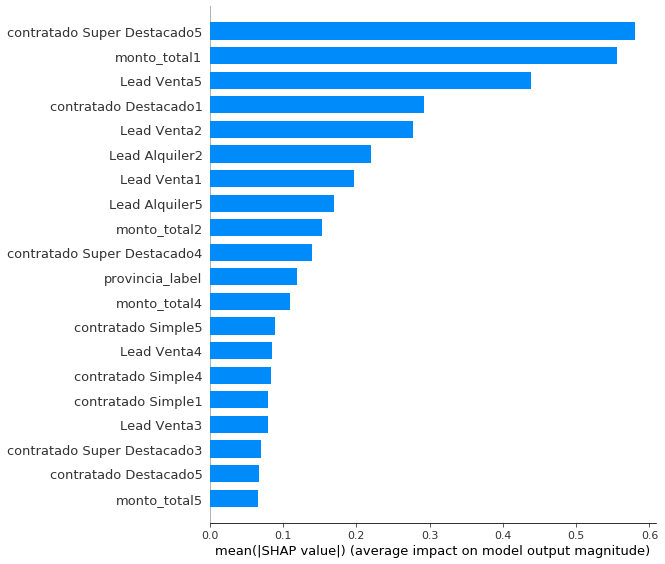

In [16]:
shap.summary_plot(shap_values, features_train, plot_type="bar")

In [17]:
features_train.columns[0], shap_values[0].min(), shap_values[0].max()

('monto_total1', -0.5828159, 0.45072177)

In [18]:
shap_values[0]

array([-5.82815886e-01, -5.66572845e-02, -1.07790254e-01, -2.37579420e-01,
       -4.78411429e-02,  1.94998384e-02,  4.61136773e-02,  4.80928421e-02,
        1.38739228e-01,  4.50721771e-01, -2.03680560e-01,  6.18714234e-03,
        9.99886543e-03, -2.49734484e-02, -5.14722727e-02, -7.83556029e-02,
        4.81745712e-02, -3.29973223e-03,  2.36640126e-02,  3.86497900e-02,
        4.29108506e-04,  1.52659439e-03,  1.59555103e-03, -2.54928673e-05,
        0.00000000e+00,  1.07045445e-04,  2.40054724e-04, -2.47262116e-03,
       -2.20947037e-03,  1.53660390e-03,  2.86470255e-04,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.75733522e-01, -1.93581030e-01, -2.46707071e-02, -4.10305485e-02,
       -4.30937916e-01,  2.10878029e-01, -3.33993256e-01,  5.60690928e-03,
       -1.21949613e-01, -3.96024615e-01,  6.91234716e-04,  4.21415530e-02,
        5.50927070e-04, -

In [34]:
shap.summary_plot??

In [37]:
shap_values

array([[-0.5828159 , -0.05665728, -0.10779025, ...,  0.10557044,
         0.00128601, -0.28963917],
       [-0.48020682, -0.05031206,  0.05899357, ...,  0.01622982,
        -0.00991677, -0.33459404],
       [-0.24594216, -0.1248218 ,  0.01937351, ..., -0.02146211,
        -0.00767329, -0.41917586],
       ...,
       [-0.5118546 ,  0.00562339, -0.09177837, ..., -0.00448484,
        -0.00823682,  0.10777693],
       [ 0.89979434, -0.16995522, -0.1637109 , ...,  0.0229095 ,
        -0.01176832,  0.10764859],
       [ 0.24687593,  0.30088016,  0.44378933, ..., -0.0051258 ,
        -0.01754255,  0.09385356]], dtype=float32)

In [32]:
shap_values[:,:1].shape

(9665, 1)

In [41]:
features_monto = features_train.filter(['monto_total1', 'monto_total12', 'monto_total3', 'monto_total4', 'monto_total5'])

In [44]:
shap_values_1 = shap.TreeExplainer(model).shap_values(features_train)

In [79]:
features_train.columns[10:15]

Index(['contratado Destacado1', 'contratado Destacado2',
       'contratado Destacado3', 'contratado Destacado4',
       'contratado Destacado5'],
      dtype='object')

In [64]:
features_train.iloc[:,40:45]

,Lead Venta1,Lead Venta2,Lead Venta3,Lead Venta4,Lead Venta5
idclientecrm,,,,,
10400002,70.0,80.0,58.0,53.0,87.0
10400005,3.0,14.0,11.0,13.0,24.0
10400007,8.0,6.0,9.0,26.0,40.0
10400010,46.0,24.0,37.0,30.0,47.0
10400014,32.0,68.0,68.0,61.0,76.0
...,...,...,...,...,...
47294162,10.0,19.0,14.0,10.0,0.0
47294172,2.0,5.0,4.0,8.0,0.0
47294187,63.0,75.0,77.0,94.0,0.0


In [54]:
shap_values_1[:,1].min(), shap_values_1[:,1].max()

(-0.94169635, 1.4549458)

In [75]:
features_train.iloc[:,45:50]

,Lead Alquiler1,Lead Alquiler2,Lead Alquiler3,Lead Alquiler4,Lead Alquiler5
idclientecrm,,,,,
10400002,389.0,408.0,407.0,253.0,425.0
10400005,140.0,162.0,75.0,101.0,200.0
10400007,115.0,211.0,105.0,20.0,201.0
10400010,162.0,146.0,85.0,105.0,124.0
10400014,439.0,682.0,801.0,991.0,654.0
...,...,...,...,...,...
47294162,0.0,0.0,0.0,0.0,0.0
47294172,0.0,0.0,0.0,0.0,0.0
47294187,311.0,138.0,81.0,79.0,0.0


In [82]:
features_train.iloc[:,10:15]

,contratado Destacado1,contratado Destacado2,contratado Destacado3,contratado Destacado4,contratado Destacado5
idclientecrm,,,,,
10400002,10.0,10.0,10.0,10.0,10.0
10400005,7.0,7.0,7.0,7.0,7.0
10400007,3.0,3.0,3.0,3.0,3.0
10400010,30.0,30.0,30.0,30.0,30.0
10400014,30.0,30.0,30.0,30.0,30.0
...,...,...,...,...,...
47294162,11.0,11.0,11.0,11.0,0.0
47294172,0.0,1.0,1.0,1.0,0.0
47294187,60.0,60.0,30.0,30.0,0.0


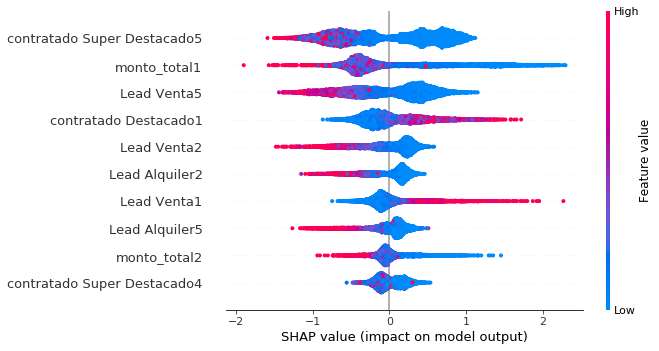

In [47]:
shap.summary_plot(shap_values, features_train, max_display = 10)

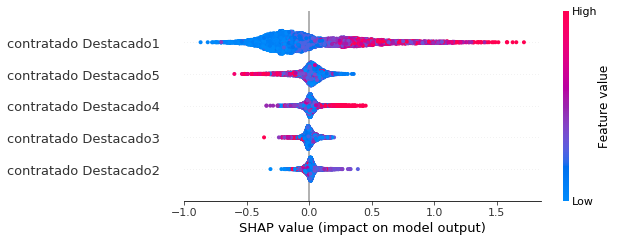

In [83]:
shap.summary_plot(shap_values[:,10:15], features_train.iloc[:,10:15], max_display = 10)

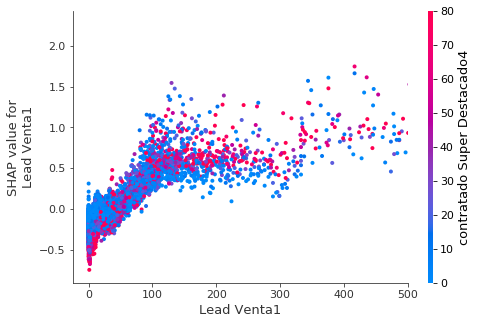

In [66]:
shap.dependence_plot('Lead Venta1', shap_values, features_train, xmax=500)

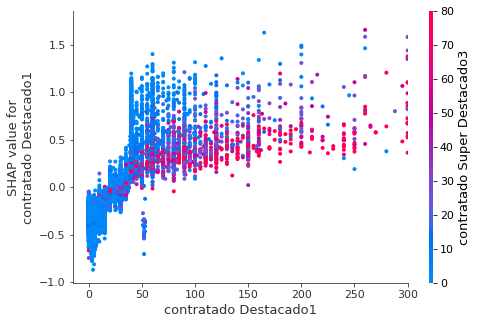

In [28]:
shap.dependence_plot('contratado Destacado1', shap_values, features_train, xmax=300)

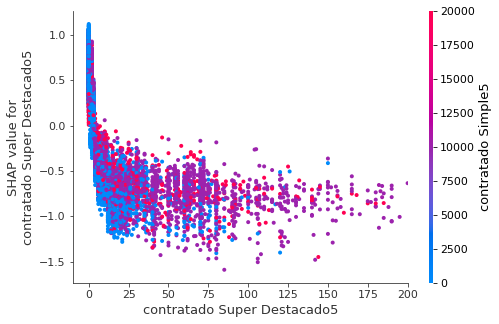

In [51]:
shap.dependence_plot('contratado Super Destacado5', shap_values, features_train, xmax=200)

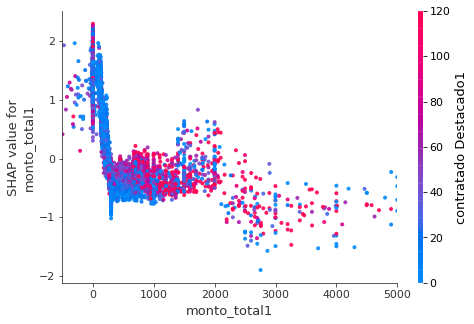

In [157]:
shap.dependence_plot('monto_total1', shap_values, features_train, xmin=-500, xmax=5000, alpha = 0.9)

In [158]:
features_train.shape

(9665, 59)

In [98]:
##### Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, 
                        shap_values_Model[j], 
                        S.iloc[[j]], 
                        figsize = (20,5), 
                        text_rotation = 0, 
                        matplotlib = True)
    return(p)

In [169]:
explainerModel = shap.TreeExplainer(model)

In [174]:
shap.TreeExplainer??

In [95]:
features_test = features[features.index.isin(test_ids)]

In [166]:
S = pd.merge(features_test, clientes_test, left_index = True, right_index = True)
S

,monto_total1,monto_total2,monto_total3,monto_total4,monto_total5,contratado Super Destacado1,contratado Super Destacado2,contratado Super Destacado3,contratado Super Destacado4,contratado Super Destacado5,...,Lead Alquiler temporal4,Lead Alquiler temporal5,CLIENTE GRUPO_label,Integrador_label,Cliente Ilimitado sin Destaque,provincia_label,Status Cliente,pred,correct,weight
idclientecrm,,,,,,,,,,,,,,,,,,,,,
10400013,199.0,199.0,199.0,199.0,199.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,0,0,5,0,1,False,0.848827
10400022,565.0,565.0,565.0,565.0,565.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,1,0,5,0,0,True,0.569146
10400052,1275.0,1275.0,1275.0,1275.0,1275.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0,1,1,5,1,0,False,0.916973
10400072,1999.0,1999.0,1999.0,1999.0,1999.0,30.0,30.0,30.0,30.0,30.0,...,0.0,0.0,1,0,0,5,0,0,True,0.768439
10400107,577.0,577.0,577.0,577.0,577.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2,1,1,5,0,0,True,0.957971
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47292563,299.0,299.0,0.0,299.0,299.0,8.0,4.0,4.0,4.0,0.0,...,0.0,0.0,2,1,0,25,1,1,True,0.608050
47294059,239.0,239.0,239.0,239.0,239.0,13.0,6.0,3.0,3.0,0.0,...,0.0,0.0,2,0,0,25,0,1,False,0.883219
47294142,448.0,448.0,448.0,299.0,299.0,24.0,24.0,4.0,4.0,0.0,...,0.0,0.0,2,1,0,25,0,1,False,0.651050


In [100]:
S = features_test

In [96]:
feature_test =features_test.reset_index(drop=False)
feature_test[feature_test['idclientecrm']==47090117]

,idclientecrm,monto_total1,monto_total2,monto_total3,monto_total4,monto_total5,contratado Super Destacado1,contratado Super Destacado2,contratado Super Destacado3,contratado Super Destacado4,...,Lead Alquiler5,Lead Alquiler temporal1,Lead Alquiler temporal2,Lead Alquiler temporal3,Lead Alquiler temporal4,Lead Alquiler temporal5,CLIENTE GRUPO_label,Integrador_label,Cliente Ilimitado sin Destaque,provincia_label
883,47090117,0.0,0.0,0.0,0.0,0.0,26.0,26.0,26.0,26.0,...,1.0,0.0,0.0,0.0,0.0,0.0,2,0,0,25


In [92]:
clientes_test.sort_values('weight', ascending = False).tail(500)

,Status Cliente,pred,correct,weight
idclientecrm,,,,
47090117,1,1,True,0.749646
47244217,0,0,True,0.747900
30006012,0,0,True,0.747532
47235707,1,1,True,0.747033
47270690,0,0,True,0.747029
...,...,...,...,...
47285908,1,1,True,0.503675
47085947,1,1,True,0.503114
47083743,0,0,True,0.502241


In [216]:
%matplotlib inline

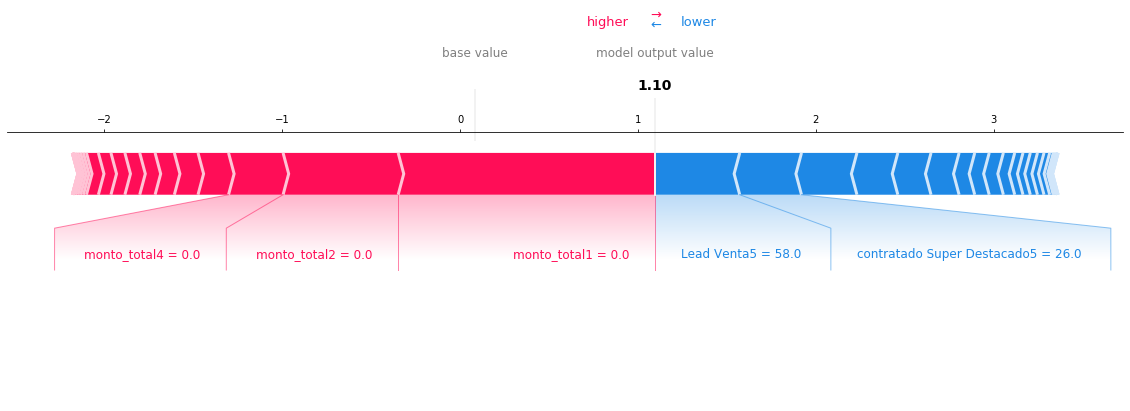

In [101]:
shap_plot(883)